In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# load utils
from src.perceptual_descriptor_selection import *
from src.make_dataset.split_data import *

# Load feature dataset and align with labels 
### (no hierarchy map available for global PCA)

In [2]:
# Load the full features
X_raw = pd.read_parquet("../data/processed/features_pca_global_3900.parquet")
X_raw.index = X_raw.index.astype(int)

# Load labels
labels = pd.read_parquet("../data/processed/core_dataset.parquet")
labels = labels.set_index("song_id")
labels.index = labels.index.astype(int)

# Align features and labels
common_ids = X_raw.index.intersection(labels.index)

X = X_raw.loc[common_ids] # apply the alignment
y_valence = labels.loc[common_ids, "valence_mean"]
y_arousal = labels.loc[common_ids, "arousal_mean"]
y_valence_std = labels.loc[common_ids, "valence_std"]
y_arousal_std = labels.loc[common_ids, "arousal_std"]

print(f"Aligned features: {X.shape}")
print(f"Songs: {len(common_ids)}")
print("Label stats:")
print(f"  Valence mean: {y_valence.mean():.3f} ± {y_valence.std():.3f}")
print(f"  Arousal mean: {y_arousal.mean():.3f} ± {y_arousal.std():.3f}")

Aligned features: (1802, 317)
Songs: 1802
Label stats:
  Valence mean: 4.904 ± 1.174
  Arousal mean: 4.814 ± 1.282


# Intra feature selection analysis

In [3]:
X_raw.columns

Index(['global_PC1', 'global_PC2', 'global_PC3', 'global_PC4', 'global_PC5',
       'global_PC6', 'global_PC7', 'global_PC8', 'global_PC9', 'global_PC10',
       ...
       'global_PC308', 'global_PC309', 'global_PC310', 'global_PC311',
       'global_PC312', 'global_PC313', 'global_PC314', 'global_PC315',
       'global_PC316', 'global_PC317'],
      dtype='object', length=317)

In [4]:
# no point in checking feature correlations here

In [5]:
# cv splits
cv5_splits = load_kfold_splits()
# custom splits
tr, val, test = load_splits_triplet()
# dev ids for final model
dev_ids = tr.union(val)

### Sweep #PCs with RF to choose best_n

In [6]:
y_target = y_valence
pc_candidates = [8, 16, 32, 64, 128, X.shape[1]]
pc_candidates = sorted({n for n in pc_candidates if n <= X.shape[1]})

In [7]:
from sklearn.base import clone
def cv_rmse_unweighted_leakfree(model, X, y, splits):
    rmses = []
    for tr_ids, va_ids in splits:
        tr = X.index.intersection(tr_ids)
        va = X.index.intersection(va_ids)

        Xtr = X.loc[tr]
        med = Xtr.median(numeric_only=True) # train-only impute
        Xtr = Xtr.fillna(med)
        Xva = X.loc[va].fillna(med)

        m = clone(model)
        m.fit(Xtr, y.loc[tr])
        p = m.predict(Xva)
        rmses.append(float(np.sqrt(((y.loc[va] - p) ** 2).mean())))
    return np.array(rmses)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rows = []
rf = RandomForestRegressor(
    n_estimators=400, max_features='sqrt', min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
for n in pc_candidates:
    Xn = X.iloc[:, :n]
    s = cv_rmse_unweighted_leakfree(rf, Xn, y_target, cv5_splits)
    rows.append({"n": int(n), "rmse_mean": s.mean(), "rmse_std": s.std()})

df_pca_rf = pd.DataFrame(rows).sort_values("n").reset_index(drop=True)
display(df_pca_rf)

,n,rmse_mean,rmse_std
0,8,0.900076,0.045609
1,16,0.880918,0.040771
2,32,0.896662,0.045171
3,64,0.921585,0.045603
4,128,0.960390,0.048569
5,317,1.022430,0.058598


In [9]:
best_n = int(df_pca_rf.loc[df_pca_rf.rmse_mean.idxmin(), "n"])
print(f"Chosen #PCs (by RF CV RMSE): n = {best_n}")

Chosen #PCs (by RF CV RMSE): n = 16


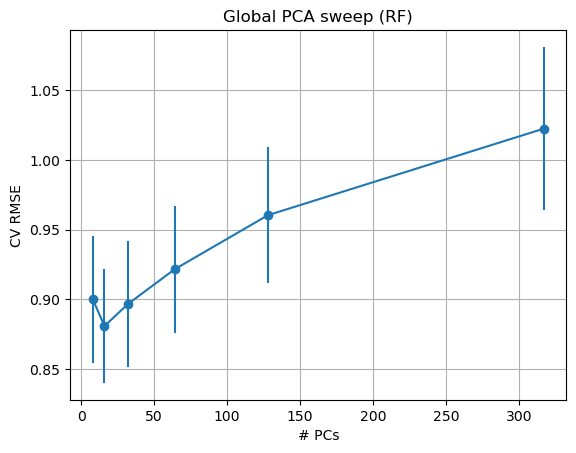

In [10]:
plt.errorbar(df_pca_rf.n, df_pca_rf.rmse_mean, yerr=df_pca_rf.rmse_std, fmt='-o')
plt.xlabel("# PCs"); plt.ylabel("CV RMSE"); plt.title("Global PCA sweep (RF)")
plt.grid(True); plt.show()

### Build X_final

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

X_pca_final = X.iloc[:, :best_n].copy()

candidates = {
    "RF":   RandomForestRegressor(
        n_estimators=400, max_features='sqrt', min_samples_leaf=2,
        random_state=42, n_jobs=-1
    ),
    "Ridge": Pipeline([("sc", StandardScaler()), ("ridge", RidgeCV(alphas=np.logspace(-3,3,13)))]),
    "OLS":   Pipeline([("sc", StandardScaler()), ("ols", LinearRegression())]),
    "GBR":  GradientBoostingRegressor(random_state=42),
}

In [12]:
rows = []
for name, model in candidates.items():
    s = cv_rmse_unweighted_leakfree(model, X_pca_final, y_target, cv5_splits)
    rows.append({"model": name, "rmse_mean": s.mean(), "rmse_std": s.std()})

In [13]:
df_models = pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)
display(df_models)

,model,rmse_mean,rmse_std
0,RF,0.880918,0.040771
1,Ridge,0.889447,0.033317
2,GBR,0.889675,0.030161
3,OLS,0.890176,0.032161


In [14]:
best_model_name = df_models.iloc[0]["model"]
best_model = candidates[best_model_name]
print(f"Best model: {best_model_name} — {df_models.iloc[0]['rmse_mean']:.4f} ± {df_models.iloc[0]['rmse_std']:.4f}")

Best model: RF — 0.8809 ± 0.0408


#### permutation check

In [15]:
from sklearn.utils import shuffle

n_perm = 30
rmse_real = df_models.iloc[0]['rmse_mean']
perm_vals = []
for _ in range(n_perm):
    y_perm = pd.Series(shuffle(y_target.values, random_state=np.random.randint(10**6)),
                       index=y_target.index)
    s = cv_rmse_unweighted_leakfree(best_model, X_pca_final, y_perm, cv5_splits)
    perm_vals.append(s.mean())

print(f"CV RMSE: real={rmse_real:.4f} vs permuted={np.mean(perm_vals):.4f} ± {np.std(perm_vals):.4f}")

CV RMSE: real=0.8809 vs permuted=1.1933 ± 0.0093


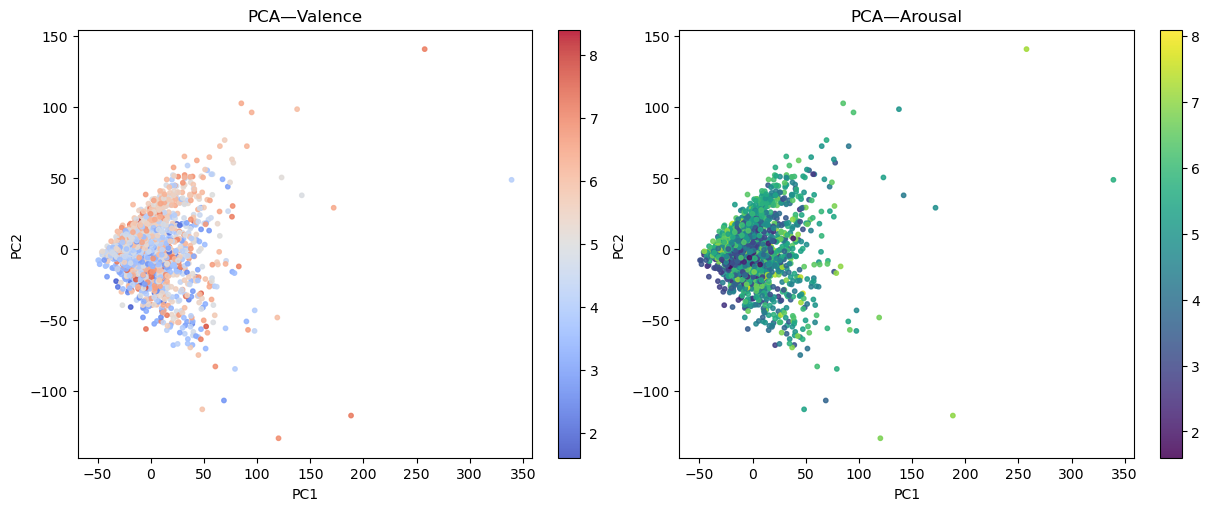

      valence   arousal
PC1  0.076488  0.105480
PC2  0.216367  0.093416


In [16]:
# PC scatterplot
PC = X.iloc[:, :2].values # PC1, PC2
idx = X.index.intersection(y_valence.index).intersection(y_arousal.index)
va = y_valence.loc[idx].astype(float).values
ar = y_arousal.loc[idx].astype(float).values

fig, ax = plt.subplots(1,2,figsize=(12,5), constrained_layout=True)
s=ax[0].scatter(PC[:,0], PC[:,1], c=va, s=10, cmap='coolwarm', alpha=.85)
ax[0].set(title=f"PCA—Valence", xlabel='PC1', ylabel='PC2'); fig.colorbar(s, ax=ax[0])
s=ax[1].scatter(PC[:,0], PC[:,1], c=ar, s=10, cmap='viridis',  alpha=.85)
ax[1].set(title=f"PCA—Arousal", xlabel='PC1', ylabel='PC2');  fig.colorbar(s, ax=ax[1])
plt.show()

# Spearman corr between existing PC1/PC2 and VA
import scipy.stats as stats
pc_df = pd.DataFrame(PC, index=X.index, columns=['PC1','PC2']).loc[idx]
corrs = pc_df.assign(valence=y_valence.loc[idx], arousal=y_arousal.loc[idx]) \
             .corr(method='spearman').loc[['PC1','PC2'], ['valence','arousal']]
print(corrs)

## Split on custom set and Normalize features

In [17]:
from sklearn.metrics import mean_squared_error

X_dev  = X_pca_final.loc[dev_ids]
X_test = X_pca_final.loc[test]

med = X_dev.median(numeric_only=True)
X_dev = X_dev.fillna(med)
X_test = X_test.fillna(med)

In [18]:
mdl_v = clone(best_model)
mdl_v.fit(X_dev, y_valence.loc[X_dev.index])
p_test_v = mdl_v.predict(X_test)
rmse_test_v = float(np.sqrt(mean_squared_error(y_valence.loc[X_test.index], p_test_v)))

mdl_a = clone(best_model)
mdl_a.fit(X_dev, y_arousal.loc[X_dev.index])
p_test_a = mdl_a.predict(X_test)
rmse_test_a = float(np.sqrt(mean_squared_error(y_arousal.loc[X_test.index], p_test_a)))

print(f"TEST — {best_model_name}")
print(f"  Valence RMSE: {rmse_test_v:.4f}")
print(f"  Arousal RMSE: {rmse_test_a:.4f}")

TEST — RF
  Valence RMSE: 0.9853
  Arousal RMSE: 0.9647


# Save everything

In [19]:
# Split the data
X_train_custom = X_pca_final.loc[tr]
X_val_custom = X_pca_final.loc[val]
X_test_custom = X_pca_final.loc[test]

Note: PCA global datasets are already normalized to scale during their creation

In [20]:
import joblib

output_dir = Path("../data/processed/derived/exp8_pca_global_3900")
output_dir.mkdir(exist_ok=True)

In [21]:
output_dir_custom = Path(output_dir / "custom_split/")
output_dir_custom.mkdir(exist_ok=True)
# Save splits
X_train_custom.to_parquet(output_dir_custom / "X_train_custom.parquet")
X_val_custom.to_parquet(output_dir_custom / "X_val_custom.parquet")
X_test_custom.to_parquet(output_dir_custom / "X_test_custom.parquet")

# Save targets
y_valence.loc[tr].to_csv(output_dir_custom / "y_valence_train_custom.csv")
y_valence.loc[val].to_csv(output_dir_custom / "y_valence_val_custom.csv")
y_valence.loc[test].to_csv(output_dir_custom / "y_valence_test_custom.csv")

y_arousal.loc[tr].to_csv(output_dir_custom / "y_arousal_train_custom.csv")
y_arousal.loc[val].to_csv(output_dir_custom / "y_arousal_val_custom.csv")
y_arousal.loc[test].to_csv(output_dir_custom / "y_arousal_test_custom.csv")

print(f"\nAll features saved to {output_dir_custom}/")


All features saved to ../data/processed/derived/exp8_pca_global_3900/custom_split/


In [22]:
X_train_custom.head(2)

,global_PC1,global_PC2,global_PC3,global_PC4,global_PC5,global_PC6,global_PC7,global_PC8,global_PC9,global_PC10,global_PC11,global_PC12,global_PC13,global_PC14,global_PC15,global_PC16
song_id,,,,,,,,,,,,,,,,
2,-2.440493,-26.555155,4.356777,6.246525,-2.567633,-11.157351,-5.350697,15.783441,2.918711,-2.277564,-6.166457,-2.733331,5.330009,-9.347106,-2.773915,2.745130
3,39.188039,-67.778577,-31.166319,-25.436110,-1.984977,-26.248983,-7.222441,-8.844561,-8.234010,17.679033,14.502523,9.562436,6.975232,-13.758210,-2.278683,-1.193204


# Model Test on the custom split only

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

output_dir_custom = Path("../data/processed/derived/exp8_pca_global_3900/custom_split/")

In [24]:
# Load scaled feature data for the custom split
X_train_custom = pd.read_parquet(output_dir_custom / "X_train_custom.parquet")
X_val_custom = pd.read_parquet(output_dir_custom / "X_val_custom.parquet")
X_test_custom = pd.read_parquet(output_dir_custom / "X_test_custom.parquet")

# Load target data for the custom split
y_valence_train_custom = pd.read_csv(output_dir_custom / "y_valence_train_custom.csv", index_col=0)
y_valence_val_custom = pd.read_csv(output_dir_custom / "y_valence_val_custom.csv", index_col=0)
y_valence_test_custom = pd.read_csv(output_dir_custom / "y_valence_test_custom.csv", index_col=0)

y_arousal_train_custom = pd.read_csv(output_dir_custom / "y_arousal_train_custom.csv", index_col=0)
y_arousal_val_custom = pd.read_csv(output_dir_custom / "y_arousal_val_custom.csv", index_col=0)
y_arousal_test_custom = pd.read_csv(output_dir_custom / "y_arousal_test_custom.csv", index_col=0)

In [25]:
# Align data for consistent samples
y_train_target_custom = y_valence_train_custom.squeeze().reindex(X_train_custom.index).dropna()
X_train_custom = X_train_custom.reindex(y_train_target_custom.index)

y_val_target_custom = y_valence_val_custom.squeeze().reindex(X_val_custom.index).dropna()
X_val_custom = X_val_custom.reindex(y_val_target_custom.index)

y_test_target_custom = y_valence_test_custom.squeeze().reindex(X_test_custom.index).dropna()
X_test_custom = X_test_custom.reindex(y_test_target_custom.index)

y_aro_train_custom = y_arousal_train_custom.squeeze().reindex(X_train_custom.index).dropna()
y_aro_val_custom = y_arousal_val_custom.squeeze().reindex(X_val_custom.index).dropna()
y_aro_test_custom = y_arousal_test_custom.squeeze().reindex(X_test_custom.index).dropna()

print("Custom Split Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_custom.shape}, y_valence_train: {y_train_target_custom.shape}")
print(f"X_val: {X_val_custom.shape}, y_valence_val: {y_val_target_custom.shape}")
print(f"X_test: {X_test_custom.shape}, y_valence_test: {y_test_target_custom.shape}")

Custom Split Data loaded and aligned. Shapes:
X_train: (1257, 16), y_valence_train: (1257,)
X_val: (276, 16), y_valence_val: (276,)
X_test: (269, 16), y_valence_test: (269,)


In [26]:
# Valence Model
model_valence_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_custom.fit(X_train_custom, y_train_target_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Predictions
y_pred_val_custom = model_valence_custom.predict(X_val_custom)
y_pred_test_custom = model_valence_custom.predict(X_test_custom)

# Metrics
mse_val_custom = mean_squared_error(y_val_target_custom, y_pred_val_custom)
rmse_val_custom = np.sqrt(mse_val_custom)
r2_val_custom = r2_score(y_val_target_custom, y_pred_val_custom)

mse_test_custom = mean_squared_error(y_test_target_custom, y_pred_test_custom)
rmse_test_custom = np.sqrt(mse_test_custom)
r2_test_custom = r2_score(y_test_target_custom, y_pred_test_custom)

print("\n--- Custom Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_custom:.4f}")
print(f"  R²:   {r2_val_custom:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_custom:.4f}")
print(f"  R²:   {r2_test_custom:.4f}")


--- Custom Split Performance ---

Validation set performance (Valence):
  RMSE: 0.9071
  R²:   0.4041

Test set performance (Valence):
  RMSE: 0.9822
  R²:   0.2965


In [28]:
# Arousal Model
model_arousal_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_custom.fit(X_train_custom, y_aro_train_custom)


,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# Predictions
y_pred_aro_val_custom = model_arousal_custom.predict(X_val_custom)
y_pred_aro_test_custom = model_arousal_custom.predict(X_test_custom)

# Metrics
mse_aro_val_custom = mean_squared_error(y_aro_val_custom, y_pred_aro_val_custom)
rmse_aro_val_custom = np.sqrt(mse_aro_val_custom)
r2_aro_val_custom = r2_score(y_aro_val_custom, y_pred_aro_val_custom)

mse_aro_test_custom = mean_squared_error(y_aro_test_custom, y_pred_aro_test_custom)
rmse_aro_test_custom = np.sqrt(mse_aro_test_custom)
r2_aro_test_custom = r2_score(y_aro_test_custom, y_pred_aro_test_custom)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_custom:.4f}")
print(f"  R²:   {r2_aro_val_custom:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_custom:.4f}")
print(f"  R²:   {r2_aro_test_custom:.4f}")


Validation set performance (Arousal):
  RMSE: 0.9024
  R²:   0.5382

Test set performance (Arousal):
  RMSE: 0.9697
  R²:   0.4480


In [30]:
from pathlib import Path
import sys
sys.path.append('..')
from src.utils import save_results

In [31]:
custom_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_custom, "R2": r2_val_custom},
        "Test": {"RMSE": rmse_test_custom, "R2": r2_test_custom}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_custom, "R2": r2_aro_val_custom},
        "Test": {"RMSE": rmse_aro_test_custom, "R2": r2_aro_test_custom}
    }
}

# Save the results for the custom split
save_results(
    name="exp8/RF_Custom_Split",
    history={},
    test_metrics=custom_split,
    save_dir=Path("../results/ML/")
)

In [32]:
import json
with open("../results/ML/exp8/RF_Custom_Split.json", 'r') as f:
    results_custom = json.load(f)

In [33]:
print("--- Model Performance on Test Set ---")

custom_metrics = results_custom['test_metrics']
v_rmse_custom = custom_metrics['Valence']['Test']['RMSE']
v_r2_custom = custom_metrics['Valence']['Test']['R2']
a_rmse_custom = custom_metrics['Arousal']['Test']['RMSE']
a_r2_custom = custom_metrics['Arousal']['Test']['R2']

print("\nCustom Split:")
print(f"  - Valence: RMSE = {v_rmse_custom:.4f}, R2 = {v_r2_custom:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_custom:.4f}, R2 = {a_r2_custom:.4f}")

--- Model Performance on Test Set ---

Custom Split:
  - Valence: RMSE = 0.9822, R2 = 0.2965
  - Arousal: RMSE = 0.9697, R2 = 0.4480
